# Lab Six for UW AMATH 563
## Assignment: Recurrent Neural Networks
## By Rebecca Lopez

In [2]:
#Import Necessary Packages & Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

#Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#Define Model
class CosineRNN(nn.Module):
    def __init__(self, p = 0.5):
        super(CosineRNN, self).__init__()
        self.rnn_layer = nn.RNN(input_size = 1, hidden_size = 128)
        self.out_layer = nn.Linear(in_features = 128, out_features = 1)
        self.p = p #Whether to use actual seq or output for next step
    
    def forward(self,seq, h = None):
        out = []
        X_in = torch.unsqueeze(seq[0],0)
        for X in seq:
            if np.random.rand()>self.p: #Use teacher forcing
                X_in = X.unsqueeze(dim = 0)
            tmp, h = self.rnn_layer(X_in, h)
            X_in = self.out_layer(tmp)
            out.append(X_in)
        return torch.stack(out).squeeze(1), h

In [6]:
seq = CosineRNN().to(device)
# seq = torch.nn.parallel.DataParallel(seq)
print(next(seq.parameters()).is_cuda)

#Define Loss function
criterion = nn.MSELoss()
#Define optimizer
optimizer = optim.Adam(seq.parameters(), lr=0.001)

max_iters = 20000
train_loss = []

#Train Model
for i in range(max_iters):
    amp = np.random.rand()*2
    data = amp*np.cos(np.linspace(0,10,100)+2*np.pi*np.random.rand())
    xs = data[:-1]
    ys = data[1:]
    X = torch.Tensor(xs).view(-1,1,1)
    y = torch.Tensor(ys)
    X,y=X.to(device),y.to(device)
    if i%100==0:
        seq.p = min(seq.p+0.1,0.85)  # encourage training longer term predictions
    optimizer.zero_grad()
    rnn_out,_ = seq(X)
    loss = criterion(rnn_out[20:].view(-1),y[20:])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if i%2000 == 0:
        print(f"i {i}, loss {loss.data:.4f}")

True
i 0, loss 0.2679
i 500, loss 0.4562
i 1000, loss 1.4430
i 1500, loss 0.0025
i 2000, loss 0.0074
i 2500, loss 0.0538
i 3000, loss 0.0660
i 3500, loss 0.4766
i 4000, loss 0.0015
i 4500, loss 0.0384
i 5000, loss 0.0172
i 5500, loss 0.3553
i 6000, loss 0.0502
i 6500, loss 0.1640
i 7000, loss 0.0260
i 7500, loss 0.0001
i 8000, loss 0.0452
i 8500, loss 0.0004
i 9000, loss 0.0367
i 9500, loss 0.0196
i 10000, loss 0.0040
i 10500, loss 0.0092
i 11000, loss 0.0311
i 11500, loss 0.1220
i 12000, loss 0.0026
i 12500, loss 0.5765
i 13000, loss 0.0539
i 13500, loss 0.2066
i 14000, loss 0.0072
i 14500, loss 0.0093
i 15000, loss 0.0229
i 15500, loss 0.0085
i 16000, loss 0.0364
i 16500, loss 0.3302
i 17000, loss 0.0203
i 17500, loss 0.0035
i 18000, loss 0.0330
i 18500, loss 0.1169
i 19000, loss 0.2093
i 19500, loss 0.5854


In [ ]:
from matplotlib import pyplot as plt
amp = np.random.rand()*2
y =amp* np.cos(np.linspace(0,100,1000)+2*np.pi*np.random.rand())

#Test Model
X = torch.Tensor(y)[:100].view(-1,1,1)
X=X.to(device)
model_out,h = seq(X)
preds = []
pred = model_out[-1].view(1,1,1)
for i in range(1000):
    pred,h = seq(pred,h)
    preds.append(pred.data.detach().cpu().numpy().ravel()[0])

val_loss = criterion(torch.Tensor(preds[:-100]), torch.Tensor(y[100:]))

Validation Loss: 1.16264808177948


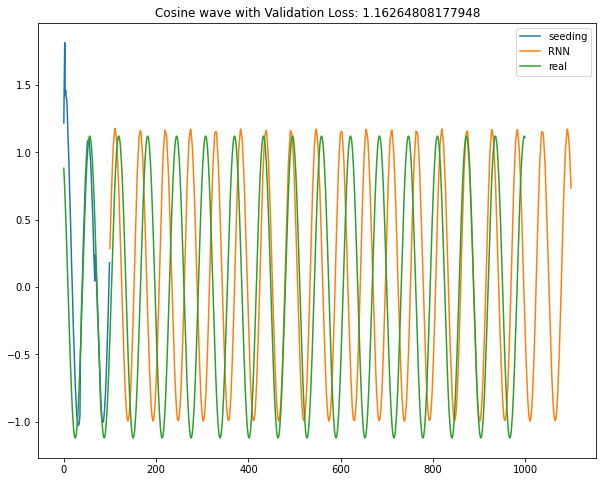

In [11]:
#Produce plot of RNN predicted y values against true y values
plt.figure(figsize=[10,8])
xs = np.arange(model_out.size(0))
plt.plot(xs,model_out.data.detach().cpu().numpy().ravel())
xs = np.arange(1000)+len(xs)
plt.plot(xs,preds)
plt.plot(y)
plt.legend(['seeding','RNN','real'])
plt.title(f'Cosine wave with Validation Loss: {val_loss}')
print(f'Validation Loss: {val_loss}')